In [1]:
import pandas as pd
import numpy as np

In [2]:
base_url = "https://atmos.nmsu.edu/PDS/data/PDS4/MAVEN/ngims_bundle/l2/"
vers = 8
rev = 1


In [3]:
def make_month_url(year, month, base_url=base_url):
    return f"{base_url}/{year}/{str(month).zfill(2)}/"



In [8]:
#month_url = make_month_url(2015, 9)
month_url = make_month_url(2015, 4)
month_url

'https://atmos.nmsu.edu/PDS/data/PDS4/MAVEN/ngims_bundle/l2//2015/04/'

In [9]:
import requests
from bs4 import  BeautifulSoup

In [10]:
def get_all_csv_filenames(url):
    req = requests.get(url)
    soup=BeautifulSoup(req.text)
    return [s for s in [x["href"] for x in soup.find_all("a", href=True)] if "csv" in s]

def create_csv_urls(month_url, filenames):
    return [month_url+f for f in filenames]


In [11]:
ion_files = [x for x in get_all_csv_filenames(month_url) if "ion" in x]
ion_urls = create_csv_urls(month_url, ion_files)
len(ion_urls)

41

In [12]:
dfs = []
for f in ion_urls:
    df = pd.read_csv(f,na_values=[' ','NaN']).drop_duplicates()
    dfs.append(df)

In [13]:
all_ion = pd.concat(dfs)

In [14]:
all_ion

,t_utc,t_unix,t_sclk,t_tid,tid,orbit,focusmode,alt,lst,long,lat,sza,ion_mass,cps_dt,abundance,sensitivity,SC_potential,precision,quality
0,2015-04-01T01:19:42,1.427851e+09,4.811232e+08,4682.203520,15446,973,osion,547.3044,12.76639,137.34490,-33.846920,20.02199,2.0,74.082613,0.094287,550,-1.214786,0.116183,SCP
1,2015-04-01T01:19:49,1.427851e+09,4.811232e+08,4689.203520,15446,973,osion,540.6853,12.77639,137.46770,-33.479930,19.78948,2.0,1370.439174,1.744195,550,-0.906077,0.027013,SCP
2,2015-04-01T01:19:51,1.427851e+09,4.811232e+08,4691.203520,15446,973,osion,538.8023,12.77917,137.50260,-33.374800,19.72326,2.0,2222.249902,2.828318,550,-0.715055,0.021213,SCP
3,2015-04-01T01:19:54,1.427851e+09,4.811232e+08,4694.203520,15446,973,osion,535.9845,12.78361,137.55490,-33.216900,19.62661,2.0,2259.302400,2.875476,550,-0.694265,0.021038,SCP
4,2015-04-01T01:19:57,1.427851e+09,4.811232e+08,4697.203520,15446,973,osion,533.1750,12.78778,137.60710,-33.058720,19.52875,2.0,2851.916175,3.629711,550,-0.703599,0.018725,SCP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17357,2015-04-30T23:55:24,1.430438e+09,4.837101e+08,5513.763662,15766,1133,osion,173.2761,11.02167,60.92347,-5.069483,15.53944,132.0,37.039747,0.067349,550,-1.690698,0.164311,SCP
17358,2015-04-30T23:55:41,1.430438e+09,4.837101e+08,5530.763662,15766,1133,osion,176.3202,11.04250,61.16565,-3.961679,15.69872,132.0,37.039747,0.067346,550,-1.965825,0.164311,SCP
17359,2015-04-30T23:55:51,1.430438e+09,4.837101e+08,5540.763662,15766,1133,osion,178.3213,11.05472,61.30745,-3.310890,15.82947,132.0,37.039747,0.067344,550,-1.858865,0.164311,SCP
17360,2015-04-30T23:55:54,1.430438e+09,4.837101e+08,5543.763662,15766,1133,osion,178.9519,11.05833,61.34990,-3.115792,15.87458,132.0,37.039747,0.067344,550,-1.895874,0.164311,SCP


In [15]:
#tid_start = 17103
#tid_end = 17177
tid_start = 15617
tid_end = 15673

ion_dd4 = all_ion[all_ion["tid"].between(tid_start, tid_end)]
ion_dd4_co2 = ion_dd4[ion_dd4["ion_mass"]==44]

In [16]:
in_dfs = []
for orb_num, orb_data in ion_dd4_co2.groupby("orbit"):
    min_alt = orb_data["alt"].min()
    min_alt_index = orb_data["alt"].idxmin()
    if type(min_alt)==pd.Series:
        min_alt = min_alt.iloc[0]
    inbound = orb_data[orb_data["t_unix"] <= orb_data.loc[min_alt_index]["t_unix"]]
    in_dfs.append(inbound)

In [17]:
ion_dd4_co2_in = pd.concat(in_dfs)

In [18]:
bins = np.arange(100, 500, 5)
bin_mids = (bins[0:-1] + bins[1:])/2
ion_dd4_co2_in["alt_bin"] = pd.cut(ion_dd4_co2_in["alt"], bins, labels=bin_mids)

In [19]:
avg = ion_dd4_co2_in[["alt_bin", "abundance"]].groupby("alt_bin").mean().rename(columns={"abundance": "abundance_mean"})
std = ion_dd4_co2_in[["alt_bin", "abundance"]].groupby("alt_bin").std().rename(columns={"abundance": "abundance_std"})
avg = pd.merge(avg, std, left_index=True, right_index=True)
avg = avg.reset_index()
avg

,alt_bin,abundance_mean,abundance_std
0,102.5,NaN,NaN
1,107.5,NaN,NaN
2,112.5,NaN,NaN
3,117.5,NaN,NaN
4,122.5,NaN,NaN
...,...,...,...
74,472.5,5.232515,5.160385
75,477.5,5.063369,5.399172
76,482.5,3.827378,4.346785
77,487.5,5.044029,5.522769


In [20]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Altitude [km]')

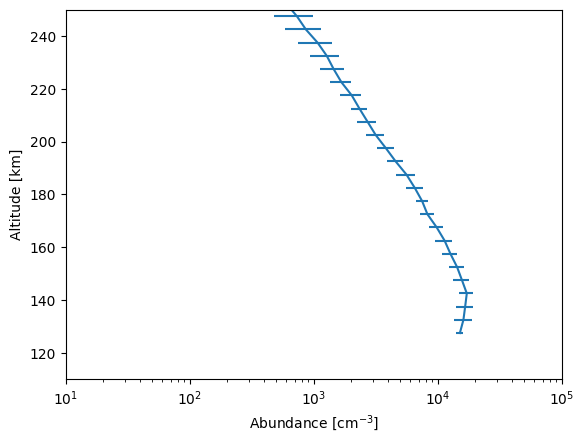

In [22]:
plt.errorbar(avg["abundance_mean"], avg["alt_bin"], xerr=avg["abundance_std"])
plt.xscale("log")
plt.ylim(110, 250)
plt.xlim(10, 1.e+5)
plt.xlabel(r"Abundance [cm$^{-3}$]")
plt.ylabel("Altitude [km]")

In [23]:
avg.dropna().rename(columns={"alt_bin": "altitude"}).to_csv("../../Desktop/DD2_ion_44.csv", index=False)

In [24]:
avg.max()

alt_bin             492.500000
abundance_mean    17138.561040
abundance_std      2630.389334
dtype: float64